In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import imgaug
import PIL
import os

In [5]:
ls ../dataset/

resized_images_small_train_A/   test_out/
resized_images_small_train_AB/  train-annotations-object-segmentation.csv
resized_images_small_train_B/   train_cats/
resized_images_total_AB/        train_cats_combined/
resized_images_train_A/         train_cats_pytorch_hed/
resized_images_train_AB/        train_cats_pytorch_hed_rand/
resized_images_train_B/         train_masks_cats/
test/


### reading data

In [42]:
def imread(path):
    return np.array(PIL.Image.open(path)).astype(np.float32) / 255.

def imshow(img):
    plt.imshow(img)
    plt.show()
    
def pair_read(path):
    img_ab = imread(path)
    img_a = img_ab[:, :256].min(axis=2)
    img_b = (img_ab[:, 256:].min(axis=2) < 1.0).astype(np.uint8)
    return img_a, img_b

In [10]:
src_dir = "../dataset/resized_images_train_AB/train"
img_names = os.listdir(src_dir)

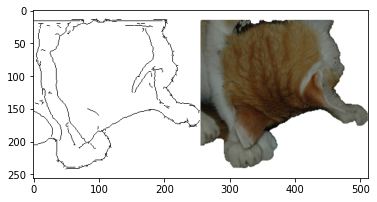

In [16]:
x = imread(os.path.join(src_dir, img_names[0]))
imshow(x)

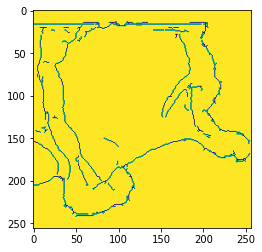

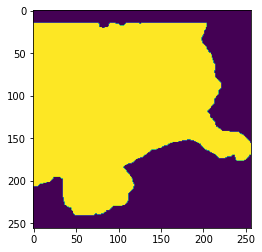

In [20]:
x_a, x_b = pair_read(os.path.join(src_dir, img_names[0]))
imshow(x_a)
imshow(x_b)

(array([ 1921.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 63615.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

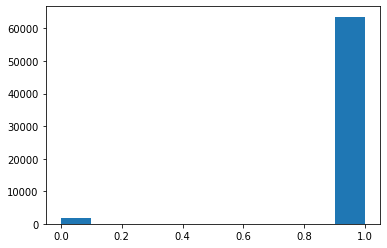

In [21]:
plt.hist(x_a.flatten())

### model

https://github.com/milesial/Pytorch-UNet

In [22]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [133]:

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, channel_multiplier=64):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        c = channel_multiplier

        self.inc = DoubleConv(n_channels, c)
        self.down1 = Down(c, 2 * c)
        self.down2 = Down(2 * c, 4 * c)
        self.down3 = Down(4 * c, 8 * c)
        factor = 2 if bilinear else 1
        self.down4 = Down(8 * c, 16 * c // factor)
        self.up1 = Up(16 * c, 8 * c // factor, bilinear)
        self.up2 = Up(8 * c, 4 * c // factor, bilinear)
        self.up3 = Up(4 * c, 2 * c // factor, bilinear)
        self.up4 = Up(2 * c, c, bilinear)
        self.outc = OutConv(c, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### training

In [134]:
device = "cuda:7"

In [135]:
model = UNet(n_channels=1, n_classes=1, channel_multiplier=16)
_ = model.to(device)

In [136]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, eps=1e-4)

In [137]:
criterion = nn.BCEWithLogitsLoss()

In [138]:
%%time
# cache the dataset
num_imgs = len(img_names)
img_As = np.zeros((num_imgs, 256, 256), dtype=np.uint8)
img_Bs = np.zeros((num_imgs, 256, 256), dtype=np.int32)
for idx in range(num_imgs):
    img_A, img_B = pair_read(os.path.join(src_dir, img_names[idx]))
    img_As[idx] = (img_A * 255).astype(np.uint8)
    img_Bs[idx] = img_B.astype(np.int32)

CPU times: user 23.8 s, sys: 633 ms, total: 24.4 s
Wall time: 24.4 s


In [139]:
import imgaug.augmenters as iaa
import imgaug as ia

aug = iaa.Sequential([
#     iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        scale={"x": (0.2, 1.0), "y": (0.2, 1.0)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-45, 45),
        shear=(-8, 8),
        mode="constant",
        cval=0,
    ),
])

In [140]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return num_imgs

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        a = img_As[idx]
        a = 255 - a  # flip so that most is black (for augmentation filling)
        b = img_Bs[idx]
        
        a, b = aug(images=a.reshape(1, 256, 256, 1), segmentation_maps=b.reshape(1, 256, 256, 1))
        
        def postprocess(t):
            return torch.tensor(t).to(torch.float).reshape(1, 256, 256)

        return postprocess(a) / 255., postprocess(b)

In [158]:
num_epochs = 10
batch_size = 64

In [143]:
dataset = CustomDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [159]:
%%time
model.train()
for i in range(num_epochs):
    for batch in loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

CPU times: user 2min 5s, sys: 1min 30s, total: 3min 35s
Wall time: 3min 33s


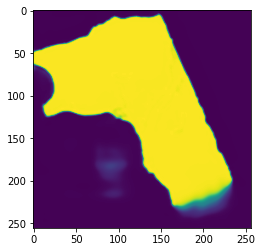

(array([37942.,  1034.,   342.,   218.,   299.,   183.,   180.,   223.,
          342., 24773.]),
 array([0.00406704, 0.10303965, 0.20201226, 0.30098486, 0.39995748,
        0.4989301 , 0.5979027 , 0.6968753 , 0.7958479 , 0.8948205 ,
        0.99379313], dtype=float32),
 <a list of 10 Patch objects>)

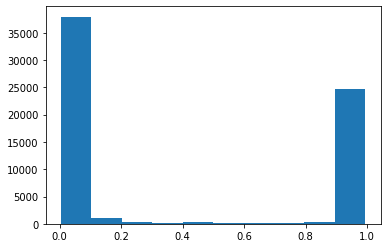

In [160]:
mask = torch.sigmoid(pred.detach()).cpu().numpy()[0, 0]
# mask = mask > 0.67
imshow(mask)
plt.hist(mask.flatten())

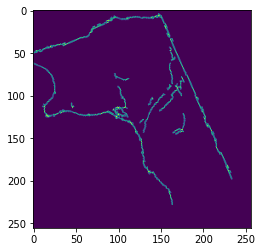

In [161]:
imshow(x.detach().cpu().numpy()[0, 0])

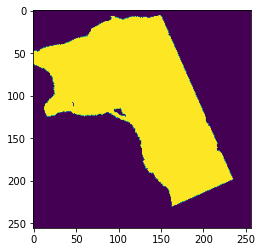

In [163]:
imshow(y.detach().cpu().numpy()[0,0])

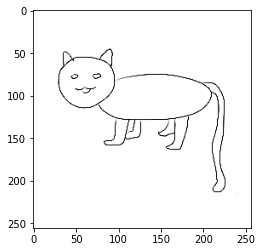

In [164]:
pth = "/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/edges2cats_single/test/ccaatt.png"
tmp = imread(pth)
imshow(tmp)

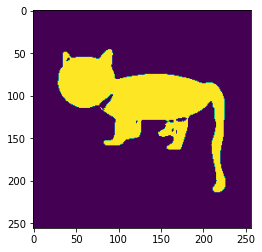

In [173]:
model.eval()
with torch.no_grad():
    res = torch.sigmoid(model(1 - torch.tensor(tmp[None, None, :, :, 0]).to(device))[0, 0])
    res = res.detach().cpu().numpy()
    res = res > 0.5
imshow(res)

In [177]:
PIL.Image.fromarray(res).save("/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/edges2cats_single/test/ccaatt_mask.png")

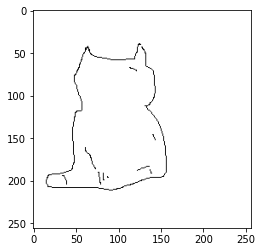

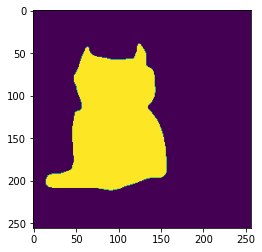

In [178]:
pth = "/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/edges2cats_single/test/pixelcat.png"
tmp = imread(pth)
imshow(tmp)
model.eval()
with torch.no_grad():
    res = torch.sigmoid(model(1 - torch.tensor(tmp[None, None, :, :, 0]).to(device))[0, 0])
    res = res.detach().cpu().numpy()
    res = res > 0.5
imshow(res)
PIL.Image.fromarray(res).save("/data/users/sash/pix2pix_cyclegan/pytorch-CycleGAN-and-pix2pix/datasets/edges2cats_single/test/pixelcat_mask.png")


In [185]:
torch.save(model.state_dict(), "edge2segment.th")

In [186]:
model.load_state_dict(torch.load("edge2segment.th"))

<All keys matched successfully>

In [187]:
tmp.shape

(256, 256, 4)